DL_MRI_reconstruction_baselines_2

SCRIPT TO TEST THE CLASSICAL CS TECHNIQUE FROM BART TOOLBOX

In [1]:
%matplotlib inline

import os
import h5py
import numpy as np
from matplotlib import pyplot as plt
import bart

import fastmri
from fastmri.data import transforms as T

In [2]:
download_path = '/DATASERVER/MIC/SHARED/NYU_FastMRI/Preprocessed'
dicom_path = os.path.join(download_path,'fastMRI_brain_DICOM')
train_path = os.path.join(download_path,'multicoil_train')
validation_path = os.path.join(download_path,'multicoil_val')
test_path = os.path.join(download_path,'multicoil_test')
fully_sampled_test_path = os.path.join(download_path,'multicoil_test_full')


In [3]:
file_name = 'file_brain_AXFLAIR_200_6002425.h5'
hf = h5py.File(os.path.join(train_path, file_name),'r')


In [4]:
volume_kspace = hf['kspace'][()]
slice_kspace = volume_kspace[10] # Choosing the 10-th slice of this volume
print(slice_kspace.dtype)
print(slice_kspace.shape)


complex64
(20, 640, 320)


First, we plot the absolute values of the Inverse Fourier Transform of some multi-coil k-space data

In [5]:
def show_coils(data, slice_nums, cmap=None):
    fig = plt.figure(figsize=(12,8))
    for i, num in enumerate(slice_nums):
        ax = plt.subplot(1, len(slice_nums), i + 1)
        im = ax.imshow(data[num], cmap=cmap)
        # Create an axes for the colorbar. The position of the axes is calculated based on the position of ax.
        # Adjust the distance between the main image and the colorbar (0.01) and the width of the colorbar (0.02) as needed.
    cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.02, ax.get_position().height])
    plt.colorbar(im, cax=cax) # Add the colorbar to the figure
    plt.show()

def kspace_to_image(slice_kspace):
    """
    Transfroms kspace data to real-valued image.
    Args:
        slice_kspace (numpy.array): Multi-coil input k-space of shape (num_coils, rows, cols) 
    Returns:
        image (numpy.array): Multi-channel image of shape (num_coils, rows, cols)
    """
    slice_kspace2 = T.to_tensor(slice_kspace)            # Convert from numpy array to pytorch tensor
    slice_image = fastmri.ifft2c(slice_kspace2)          # Apply Inverse Fourier Transform to get the complex image
    slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
    return slice_image_abs


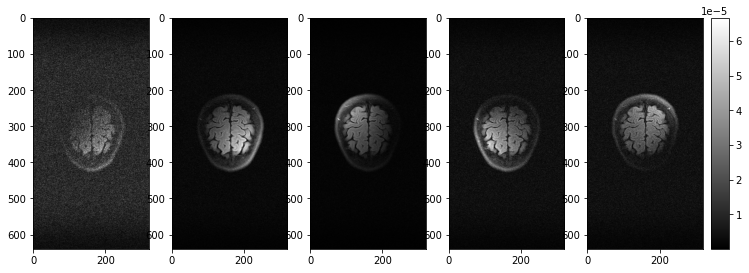

In [6]:
show_coils(kspace_to_image(slice_kspace), [0, 2, 5, 7, 10], cmap='gray')


Now, let's try to estimate the sensitivity maps using the ESPIRiT method provided by the BART toolbox

In [7]:
! bart

BART. Available commands are:
avg         bench       bin         bitmask     cabs        caldir      
calmat      carg        casorati    cc          ccapply     cdf97       
circshift   conj        conv        conway      copy        cpyphs      
creal       crop        delta       ecalib      ecaltwo     estdelay    
estdims     estshift    estvar      extract     fakeksp     fft         
fftmod      fftrot      fftshift    filter      flatten     flip        
fmac        homodyne    index       invert      itsense     join        
looklocker  lrmatrix    mandelbrot  mip         moba        mobafit     
nlinv       noise       normalize   nrmse       nufft       ones        
pattern     phantom     pics        pocsense    poisson     pol2mask    
poly        repmat      reshape     resize      rmfreq      rof         
roistat     rss         rtnlinv     sake        saxpy       scale       
sdot        show        signal      slice       spow        sqpics      
squeeze     ssa      

In [8]:
! bart ecalib -h

Usage: ecalib [-t f] [-c f] [-k ...] [-r ...] [-m d] [-S] [-W] [-I] [-1] [-P] [-v f] [-a] [-d d] <kspace> <sensitivites> [<ev-maps>]

Estimate coil sensitivities using ESPIRiT calibration.
Optionally outputs the eigenvalue maps.

-t threshold      	This determined the size of the null-space.
-c crop_value      	Crop the sensitivities if the eigenvalue is smaller than {crop_value}.
-k ksize      	kernel size
-r cal_size      	Limits the size of the calibration region.
-m maps      	Number of maps to compute.
-S		create maps with smooth transitions (Soft-SENSE).
-W		soft-weighting of the singular vectors.
-I		intensity correction
-1		perform only first part of the calibration
-P		Do not rotate the phase with respect to the first principal component
-v variance      	Variance of noise in data.
-a		Automatically pick thresholds.
-d level      	Debug level
-h		help


In [9]:
def estimate_sensitivity_maps(kspace):
    ''' 
    Args:
        kspace (numpy.array): slice kspace of shape (num_coils, rows, cols)
    Returns:
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    # Add extra dimension, because the ESPIRiT method expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    # Estimate sensitivity maps with ESPIRiT method
    S = bart.bart(1, "ecalib -d0 -m1", kspace_perm)
    # Undo the previous operations to get the original data structure back
    S = np.moveaxis(S.squeeze(), 2, 0)
    return S


In [10]:
# Plots the first nc estimated sensitivity maps
def show_ensitivity_maps(S, nc):
    fig = plt.figure()
    for i in range(nc):
        plt.subplot(1, nc, i+1)
        plt.imshow(abs(S[i,:,:]), cmap='gray')
        plt.title('S {}'.format(i+1))

def show_select_sensitivity_maps(S, nc_list):
    fig = plt.figure(figsize=(12,8))
    i = 0
    for nc in nc_list:
        plt.subplot(1, len(nc_list), i+1)
        plt.imshow(abs(S[nc,:,:]), cmap='gray')
        plt.title('S {}'.format(i+1))
        i += 1


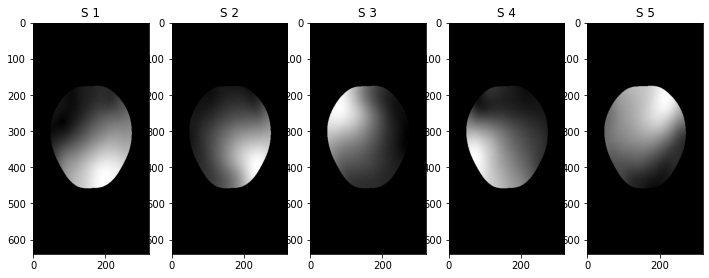

In [11]:
S = estimate_sensitivity_maps(slice_kspace)
show_select_sensitivity_maps(S, [0, 2, 5, 7, 10])


Let's try to combine the multi-coil images based on the estimated coil sensitivity maps

In [12]:
def apply_multi_channel_data_standardization(kspace, S):
    """
    Applies Multi-channel standardization to multi-coil data using sensitivity maps estimated with ESPIRiT method,
    as described by AIRS Medical team.
    Args:
        kspace  (numpy.array): slice kspace of shape (num_coils, rows, cols)
        S       (numpy.array): Estimated sensitivity maps given by ESPIRiT
    Returns:
        numpy.array: Standardized data of shape (num_coils+1, rows, cols)
    """
    # First get the image
    kspace2 = T.to_tensor(kspace)           # Convert from numpy array to pytorch tensor
    image2 = fastmri.ifft2c(kspace2)        # Apply Inverse Fourier Transform to get the complex image
    image = T.tensor_to_complex_np(image2)  # Convert back to a numpy array
    # Use S to combine the multi-channel data using a conjugate sum: I_combined = sum(conj(S_i)*I_i)
    M_comb = np.sum(np.multiply(np.conj(S), image), axis=0)
    # Now, we can compute a residual image to consider sensitivity estimation errors or artifacts
    M_res = image - np.multiply(S, M_comb)
    M_comb = np.expand_dims(M_comb, axis=0)
    M_out = np.concatenate((M_comb, M_res))
    return M_out


In [13]:
standardized_image = apply_multi_channel_data_standardization(slice_kspace, S)


In [14]:
# As we have 20 coils in this scan, this should consist of 1 final image I_combined and 20 residual images: I_i_res = I_i - S_i * I_combined
standardized_image.shape


(21, 640, 320)

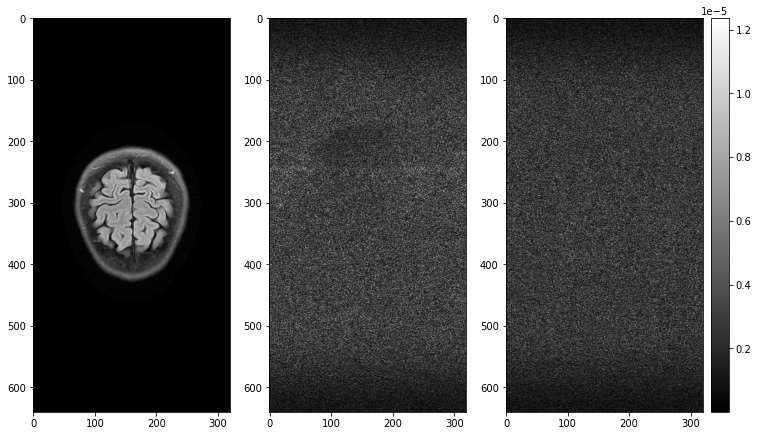

In [15]:
show_coils(fastmri.complex_abs(T.to_tensor(standardized_image)), [0, 5, 10], cmap='gray')


Now, let's mask our k-space, estimate our sensitivity maps again and try to perform an L1-wavelet CS reconstruction

In [17]:
import scipy.io as sio

mat_file = sio.loadmat('/DATASERVER/MIC/GENERAL/STUDENTS/aslock2/fastMRI-hybrid-modelling/fastMRI/sampling_profiles_CS.mat')
mat_file.keys()


dict_keys(['__header__', '__version__', '__globals__', 'm256_CS1_mask', 'm256_CS2_mask', 'm256_CS4_mask', 'm256_CS6_mask', 'm256_CS8_mask', 'm256_full_mask', 'm320_CS1_mask', 'm320_CS2_mask', 'm320_CS4_mask', 'm320_CS6_mask', 'm320_CS8_mask', 'm320_full_mask'])

In [18]:
mat_file['m320_CS4_mask'][150:170]


array([[0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0]], dtype=uint8)

In [19]:
mat_file['m320_CS8_mask'][150:170]


array([[0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0]], dtype=uint8)

In [21]:
# First, we estimate our sensitivity maps as if we have undersampled data with an ACS region

from fastmri.data.subsample import RandomMaskFunc

def apply_mask(slice_kspace, mask_func):
    ''' 
    Args:
        slice_kspace (numpy.array)
        mask_func (class)
    Returns:
        masked_kspace (numpy.array)
        mask (torch.tensor)
    '''
    slice_kspace_T = T.to_tensor(slice_kspace)
    masked_kspace_T, mask = T.apply_mask(slice_kspace_T, mask_func)   # Apply the mask to k-space
    masked_kspace = T.tensor_to_complex_np(masked_kspace_T)
    return masked_kspace, mask

mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
masked_kspace, mask = apply_mask(slice_kspace, mask_func)


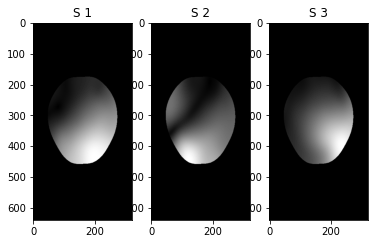

In [22]:
S = estimate_sensitivity_maps(masked_kspace)
show_ensitivity_maps(S, 3)


In [23]:
# Now, we can start looking at CS undersampling as used in the real world

def closer_to_4_or_8(float):
    diff_4 = np.abs(float - 4)
    diff_8 = np.abs(float - 8)

    if diff_4 < diff_8:
        return int(4)
    elif diff_8 < diff_4:
        return int(8)

def generate_array(shape, R, mat_file, tensor_out):
    if R == 4:
        array = mat_file['m320_CS4_mask'].squeeze()
    elif R == 8:
        array = mat_file['m320_CS8_mask'].squeeze()
    else:
        raise ValueError('Unrecognized acceleration factor specified. Must be 4 or 8.')
    # Calculate padding needed to reach the desired length
    desired_length = shape[-1]
    padding_needed = desired_length - len(array)
    if padding_needed > 0:
        # Calculate padding width for symmetric padding
        padding_width = (padding_needed // 2, padding_needed - padding_needed // 2)
        # Pad the array symmetrically
        array = np.pad(array, padding_width, mode='symmetric')
    elif padding_needed < 0:
        # Calculate trimming indices for symmetric trimming
        trim_start = -padding_needed // 2
        trim_end = len(array) + padding_needed // 2
        # Trim the array symmetrically
        array = array[trim_start:trim_end]
    # Make array compatible with fastmri mask function class
    for i in range(len(shape)-1):
        array = np.expand_dims(array, 0)
    if tensor_out:
        array = T.to_tensor(array)
    return array


In [24]:
# CS type mask
mask = generate_array(slice_kspace.shape, closer_to_4_or_8(4.5), mat_file, tensor_out=False)
masked_kspace = slice_kspace * mask + 0.0


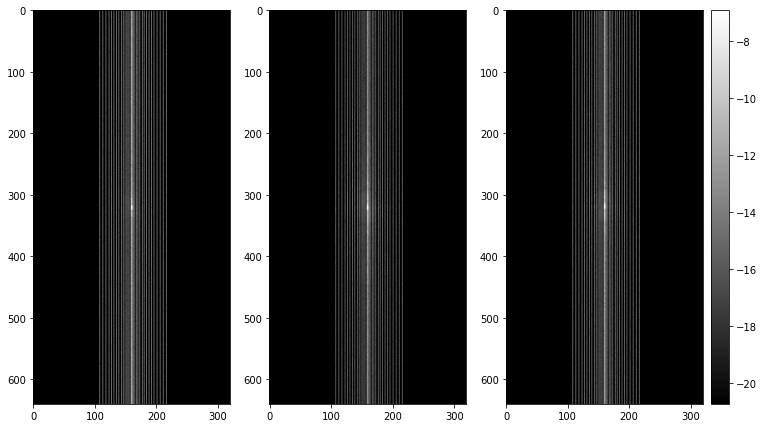

In [25]:
show_coils(np.log(np.abs(masked_kspace) + 1e-9), [0, 5, 10], cmap='gray')


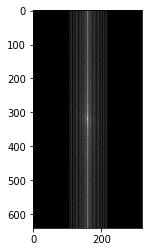

In [26]:
plt.imshow(np.log(np.abs(masked_kspace[5]) + 1e-9), cmap='gray')


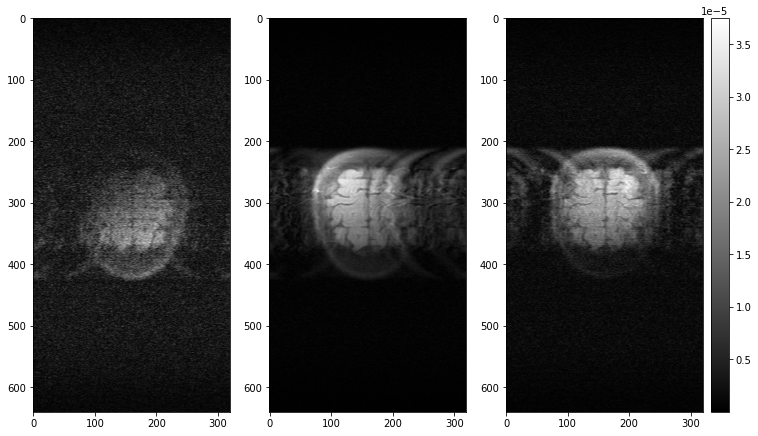

In [27]:
show_coils(kspace_to_image(masked_kspace), [0, 5, 10], cmap='gray')


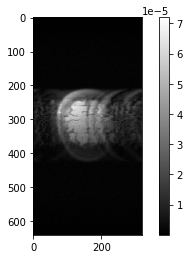

In [28]:
plt.imshow(kspace_to_image(masked_kspace[5]), cmap='gray')
plt.colorbar()


In [29]:
! bart pics -h


Usage: pics [-l ...] [-r f] [-R ...] [-c] [-s f] [-i d] [-t <string>] [-n] [-N] [-g] [-G d] [-p <string>] [-I ...] [-b d] [-e] [-T <string>] [-W <string>] [-d d] [-O d] [-o f] [-u f] [-C d] [-q f] [-f f] [-m ...] [-w f] [-S] [-L d] [-K] [-B <string>] [-P f] [-a ...] [-M] [-U,--lowmem] <kspace> <sensitivities> <output>

Parallel-imaging compressed-sensing reconstruction.

-l1/-l2		toggle l1-wavelet or l2 regularization.
-r lambda      	regularization parameter
-R <T>:A:B:C	generalized regularization options (-Rh for help)
-c		real-value constraint
-s step      	iteration stepsize
-i iter      	max. number of iterations
-t file      	k-space trajectory
-n		disable random wavelet cycle spinning
-N		do fully overlapping LLR blocks
-g		use GPU
-G gpun      	use GPU device gpun
-p file      	pattern or weights
-I		select IST
-b blk      	Lowrank block size
-e		Scale stepsize based on max. eigenvalue
-T file      	(truth file)
-W <img>      	Warm start with <img>
-d level      	Debug level
-O

In [30]:
! bart pics -Rh


Generalized regularization options (experimental)

-R <T>:A:B:C	<T> is regularization type (single letter),
		A is transform flags, B is joint threshold flags,
		and C is regularization value. Specify any number
		of regularization terms.

-R Q:C    	l2-norm in image domain
-R I:B:C  	l1-norm in image domain
-R W:A:B:C	l1-wavelet
-R N:A:B:C	Normalized Iterative Hard Thresholding (NIHT), image domain
		C is an integer percentage, i.e. from 0-100
-R H:A:B:C	NIHT, wavelet domain
-R F:A:B:C	l1-Fourier
-R T:A:B:C	total variation
-R T:7:0:.01	3D isotropic total variation with 0.01 regularization.
-R L:7:7:.02	Locally low rank with spatial decimation and 0.02 regularization.
-R M:7:7:.03	Multi-scale low rank with spatial decimation and 0.03 regularization.


In [31]:
def CS(kspace, S, lamda=0.005, num_iter=50):
    ''' 
    Performs CS reconstruction
    https://mrirecon.github.io/bart/

    Args:
        kspace (numpy.array): Slice kspace of shape (num_coils, rows, cols)
        S (numpy.array): Estimated sensitivity maps given by ESPIRiT of shape (num_coils, rows, cols)
        lamda: Value of the hyperparameter / regularizer of the l1 norm term
        num_iter: The amount of iterations the algorithm can run
    Returns:
        reconstruction (numpy.array): Estimated CS reconstruction of shape (rows, cols))
    '''
    # Move coil axis to the back as expected by BART
    kspace_perm = np.moveaxis(kspace, 0, 2)
    S_perm = np.moveaxis(S, 0, 2)
    # Add extra dimension, because BART expects a 4D input array where the third dimension represents the batch size.
    kspace_perm = np.expand_dims(kspace_perm, axis=2)
    S_perm = np.expand_dims(S_perm, axis=2)
    # Perform CS reconstruction
    reconstruction = bart.bart(1, 'pics -S -l1 -r {} -i {}'.format(lamda, num_iter), kspace_perm, S_perm)
    return reconstruction


In [32]:
reconstruction = CS(masked_kspace, S)


In [33]:
print(reconstruction.shape)
print(reconstruction.dtype)


(640, 320)
complex64


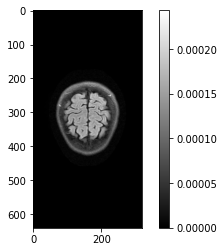

In [34]:
plt.imshow(np.abs(reconstruction), cmap='gray')
plt.colorbar()


Let's compare this to the normal RSS reconstruction

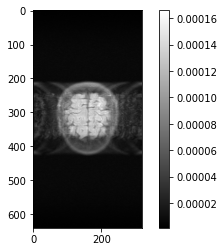

In [35]:
rss_image = fastmri.ifft2c(T.to_tensor(masked_kspace))
rss_image = fastmri.complex_abs(rss_image)
rss_image = fastmri.rss(rss_image, dim=0)
plt.imshow(np.abs(rss_image.numpy()), cmap='gray')
plt.colorbar()
